### NPSC psudeo-extension stands for NuPlan Scenario Collection. 
#### It is a pkl file with the naming convention `filename.npsc.pkl` that contains:
* The data structure of a dictionary of scenario modifications.
* The `DATASET_PARAMS` list of filters in order to extract the correct scenarios to modify.

In [1]:
import logging
import random
import nest_asyncio
import pandas as pd

nest_asyncio.apply()

import torch

torch.cuda.is_available()

import os
from pathlib import Path
import tempfile

from shutil import rmtree
from typing import List, Optional, Union

from nuplan.planning.script.run_simulation import main as main_simulation

In [2]:
%env NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
%env NUPLAN_MAPS_ROOT=../../data/nuplan/maps
%env NUPLAN_EXP_ROOT=../../data/nuplan/exp
%env NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/
%pwd

env: NUPLAN_DATA_ROOT=../../../datasets/nuplan/dataset
env: NUPLAN_MAPS_ROOT=../../data/nuplan/maps
env: NUPLAN_EXP_ROOT=../../data/nuplan/exp
env: NUPLAN_DEVKIT_ROOT=../../nuplan-devkit/


'/home/ehdykhne/nuplan-devkit/experiments'

In [3]:
import hydra
import pytorch_lightning as pl
from omegaconf import DictConfig, OmegaConf

from nuplan.common.utils.s3_utils import is_s3_path
from nuplan.planning.script.builders.simulation_builder import build_simulations
from nuplan.planning.script.builders.simulation_callback_builder import (
    build_callbacks_worker,
    build_simulation_callbacks,
)
from nuplan.planning.script.utils import (
    run_runners,
    set_default_path,
    set_up_common_builder,
)
from nuplan.planning.simulation.planner.abstract_planner import AbstractPlanner

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# If set, use the env. variable to overwrite the default dataset and experiment paths
set_default_path()

# If set, use the env. variable to overwrite the Hydra config
CONFIG_PATH = os.getenv("NUPLAN_HYDRA_CONFIG_PATH", "config/simulation")

if os.environ.get("NUPLAN_HYDRA_CONFIG_PATH") is not None:
    CONFIG_PATH = os.path.join("../../../../", CONFIG_PATH)

if os.path.basename(CONFIG_PATH) != "simulation":
    CONFIG_PATH = os.path.join(CONFIG_PATH, "simulation")
CONFIG_NAME = "default_simulation"

In [4]:
from tutorials.utils.tutorial_utils import construct_simulation_hydra_paths

# Location of paths with all simulation configs
BASE_CONFIG_PATH = os.path.join(
    os.getenv("NUPLAN_TUTORIAL_PATH", ""), "../nuplan/planning/script"
)
simulation_hydra_paths = construct_simulation_hydra_paths(BASE_CONFIG_PATH)

In [5]:
import pickle

EXPERIMENT_NAME = "pdm_closed_pdm_closed_diverge_pure_scen_1400"
modification_file_path = "npsc_files/" + EXPERIMENT_NAME + ".npsc.pkl"
with open(modification_file_path, "rb") as output_file:
    mod_list_dict = pickle.load(output_file)
    print(list(mod_list_dict.keys()))
    DATASET_PARAMS = pickle.load(output_file)

print(DATASET_PARAMS)

['ea29f4aa6dd2598c', 'b0646a16830258a6', 'ec5653d7ba5a5464', 'c6492065deb75fa1', '694b93d17f1355be', '17a1b01f3ae45487']
['scenario_builder=val', 'scenario_filter=all_scenarios', "scenario_filter.scenario_types=['starting_left_turn', 'starting_right_turn', 'starting_straight_stop_sign_intersection_traversal', 'starting_straight_traffic_light_intersection_traversal', 'starting_unprotected_cross_turn', 'starting_unprotected_noncross_turn', 'traversing_intersection', 'traversing_traffic_light_intersection']", 'scenario_filter.ego_displacement_minimum_m=10', 'scenario_filter.map_names=[sg-one-north, us-ma-boston, us-pa-pittsburgh-hazelwood, us-nv-las-vegas-strip]', 'scenario_filter.num_scenarios_per_type=1400']


In [6]:
urban_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt"
gc_pgp_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/gc_pgp_checkpoint.ckpt"
hybrid_ckpt = "/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/pdm_offset_checkpoint.ckpt"
#'/home/ehdykhne/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'
#'/home/ehdykhne/Repos/nuplan-devkit/experiments/pretrained_checkpoints/urbandriver_checkpoint.ckpt'

In [7]:
# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=simulation_hydra_paths.config_path)

# Compose the configuration
print(simulation_hydra_paths.config_name)
cfg_occ = hydra.compose(
    config_name=simulation_hydra_paths.config_name,
    overrides=[
        # planner
        ################################################
        "planner=pdm_closed_planner",  # [ml_planner, pdm_hybrid_planner, pdm_closed_planner, idm_planner, log_future_planner, simple_planner]
        # planner occlusion
        ################################################
        "+occlusion_cfg.occlusion=true",
        "+occlusion_cfg.manager_type=wedge",  # options: [range, shadow, wedge]
        "+occlusion_cfg.uncloak_reaction_time=1.5",
        "+occlusion_cfg.notice_threshold=1.0",
        ################################################
        # obs
        ################################################
        f"observation.planner_type=pdm_closed",
        ################################################
        # obs occlusion
        ################################################
        f"observation.occlusion_cfg.occlusion=True",
        f"observation.occlusion_cfg.manager_type=wedge",
        f"+observation.occlusion_cfg.uncloak_reaction_time=1.5",
        f"+observation.occlusion_cfg.notice_threshold=1.0",
        ################################################
        # scenario modification
        "+modify_scenario_simulations=true",
        "+second_testing_round=true",
        f"+modification_file_path={modification_file_path}",
        # "+remove_other_agents=true",
        ################################################
        # misc
        ################################################
        "+simulation=closed_loop_multiagent",  # [open_loop_boxes, closed_loop_nonreactive_agents, closed_loop_reactive_agents, closed_loop_multiagent]
        "worker=ray_distributed",  # [sequential, ray_distributed]
        "hydra.searchpath=[pkg://tuplan_garage.planning.script.config.common, pkg://tuplan_garage.planning.script.config.simulation, pkg://nuplan.planning.script.config.common, pkg://nuplan.planning.script.experiments]",
        *DATASET_PARAMS,
        ################################################
    ],
)

output_folder_occ = cfg_occ.output_dir
print('output_folder_occ = "' + output_folder_occ + '"')

default_simulation
output_folder_occ = "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.15.07.07.35"


### Now, we run the simulations

In [8]:
# Run the simulation loop (real-time visualization not yet supported, see next section for visualization)
main_simulation(cfg_occ)

Global seed set to 0
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback...
INFO:nuplan.planning.script.builders.main_callback_builder:Building MultiMainCallback: 4...DONE!


2024-05-15 07:07:35,605 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:19}  Building WorkerPool...
2024-05-15 07:07:35,642 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_ray.py:78}  Starting ray local!


2024-05-15 07:07:37,271	INFO worker.py:1636 -- Started a local Ray instance.


2024-05-15 07:07:37,937 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:101}  Worker: RayDistributed
2024-05-15 07:07:37,937 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/utils/multithreading/worker_pool.py:102}  Number of nodes: 1
Number of CPUs per node: 32
Number of GPUs per node: 4
Number of threads across all nodes: 32
2024-05-15 07:07:37,937 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/worker_pool_builder.py:27}  Building WorkerPool...DONE!
2024-05-15 07:07:37,938 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:32}  Building experiment folders...
2024-05-15 07:07:37,938 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_builder.py:35}  

	Folder where all results are stored: ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.15.07.07.35

2024-05-15 07:07:37,939 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/folder_build

Ray objects: 100%|██████████| 32/32 [00:07<00:00,  4.16it/s]
(raylet) [2024-05-15 07:07:47,246 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500047802368; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:07:57,248 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500049928192; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:08:07,251 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500042108928; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:08:17,255 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is ov

2024-05-15 07:11:01,734 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:84}  Building metric engines...
2024-05-15 07:11:01,881 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:86}  Building metric engines...DONE
2024-05-15 07:11:01,881 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:90}  Building simulations from 8789 scenarios...


(raylet) [2024-05-15 07:11:07,305 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500049522688; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:11:17,307 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500049518592; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:11:27,309 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500049518592; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:11:37,311 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500049489920; capacity: 1612571

2024-05-15 07:12:49,380 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:152}  Modyfing Scenarios...
# roadblock ids 7
# unique roadblock ids 5
unique roadblock ids ['51576', '50278', '50800', '51253', '51101']
[
	'17a1b01f3ae45487',
	'694b93d17f1355be',
	'b0646a16830258a6',
	'c6492065deb75fa1',
	'ea29f4aa6dd2598c',
	'ec5653d7ba5a5464'
]
2024-05-15 07:12:50,393 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:219}  Created 7 modified scenarios from 8789 scenarios, 6 of which were modifiable.
2024-05-15 07:12:50,393 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/simulation_builder.py:220}  Building simulations...DONE!
2024-05-15 07:12:50,423 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/run_simulation.py:113}  Running simulation...
2024-05-15 07:12:50,423 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:138}  Executing runners...
2024-05-15 07:12:50,424 INFO 

Ray objects:   0%|          | 0/7 [00:00<?, ?it/s](raylet) [2024-05-15 07:12:57,330 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500049240064; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:13:07,336 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500049235968; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:13:17,342 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 500049231872; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:13:27,348 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full

2024-05-15 07:13:51,068 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:129}  Number of successful simulations: 7
2024-05-15 07:13:51,069 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/runner/executor.py:130}  Number of failed simulations: 0
2024-05-15 07:13:51,069 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:147}  Finished executing runners!
2024-05-15 07:13:51,075 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/utils.py:74}  Saved runner reports to ../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.15.07.07.35/runner_report.parquet
2024-05-15 07:13:51,075 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/time_callback.py:27}  Simulation duration: 00:06:15 [HH:MM:SS]
2024-05-15 07:13:51,213 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/simulation/main_callback/metric_file_callback.py:79}  Metric files integration: 00:00:00 [HH:MM:SS]
2024-05-15 07:13:51,278 I

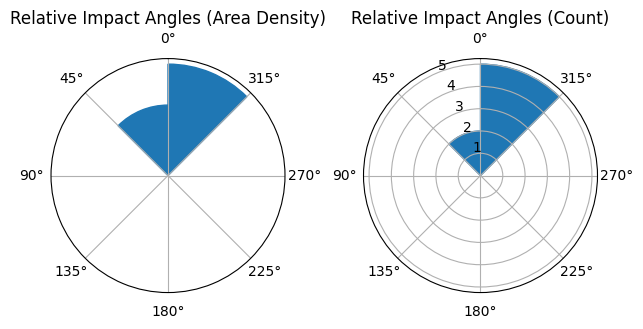

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from vis_utils import circular_hist

%matplotlib inline

# # seq
# output_folder_occ_s = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.26.07.27.19"
# )
# #cross
# output_folder_occ_c = (
#     "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.26.07.37.26"
# )
# #merge
# output_folder_occ_m = (
#   "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.26.07.42.37"
# )
# #diverge
# output_folder_occ_d = (
#   "../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.04.26.07.45.40"
# )

file_path = output_folder_occ + "/metrics/" + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path)
relative_angles_of_impact_df = df[
    "relative_impact_angle_at_first_ego_collision_with_vehicles_stat_value"
]
relative_angles_of_impact = relative_angles_of_impact_df.to_numpy()

# fig, ax = plt.subplots(1, 2)
# fig.tight_layout()
figp, axp = plt.subplots(1, 2, subplot_kw=dict(projection="polar"))
figp.tight_layout()

# Visualise by area of bins
circular_hist(
    axp[0],
    relative_angles_of_impact,
    bins=8,
    density=True,
    offset=np.pi / 2,
    gaps=False,
)

circular_hist(
    axp[1],
    relative_angles_of_impact,
    bins=8,
    density=False,
    offset=np.pi / 2,
    gaps=False,
)


axp[0].title.set_text("Relative Impact Angles (Area Density)")
axp[1].title.set_text("Relative Impact Angles (Count)")

In [10]:
path = output_folder_occ + "/metrics/"
file_path_1 = path + "no_ego_at_fault_collisions.parquet"
df = pd.read_parquet(file_path_1)
df = df.loc[df["number_of_ego_collisions_with_vehicles_stat_value"] != 0]
df = df["scenario_name"]


scenario_list = df.tolist()
print("num : ", len(scenario_list))
for item in scenario_list:
    print(item)

num :  7
ea29f4aa6dd2598c_diverge_conflict_injection_and_occlusion_injection_053522
b0646a16830258a6_diverge_conflict_injection_and_occlusion_injection_046898
ec5653d7ba5a5464_diverge_conflict_injection_and_occlusion_injection_053410
c6492065deb75fa1_diverge_conflict_injection_and_occlusion_injection_053029
694b93d17f1355be_diverge_conflict_injection_and_occlusion_injection_153139
17a1b01f3ae45487_diverge_conflict_injection_and_occlusion_injection_053522
694b93d17f1355be_diverge_conflict_injection_and_occlusion_injection_053139


In [11]:
import re

output_folder = [output_folder_occ]

print(output_folder_occ)

CONFIG_PATH = "../nuplan/planning/script/config/nuboard"
CONFIG_NAME = "default_nuboard"

# Initialize configuration management system
hydra.core.global_hydra.GlobalHydra.instance().clear()  # reinitialize hydra if already initialized
hydra.initialize(config_path=CONFIG_PATH)
scenario_builder = None
for item in DATASET_PARAMS:
    parts = re.split("=", item, 1)
    if parts[0] == "scenario_builder":
        scenario_builder = parts[1]
if scenario_builder is None:
    raise ValueError("scenario_builder not specified in the dataset parameters")
print(scenario_builder)
# Compose the configuration
cfg = hydra.compose(
    config_name=CONFIG_NAME,
    overrides=[
        f"scenario_builder={scenario_builder}",  # set the database (same as simulation) used to fetch data for visualization
        f"simulation_path={output_folder}",  # [output_folder, output_folder_alt] nuboard file path(s), if left empty the user can open the file inside nuBoard
    ],
)

../../data/nuplan/exp/exp/simulation/closed_loop_multiagent/2024.05.15.07.07.35
val


### Launch NuBoard

In [12]:
from nuplan.planning.script.run_nuboard import main as main_nuboard

# Run nuBoard
main_nuboard(cfg)

2024-05-15 07:13:52,095 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:18}  Building AbstractScenarioBuilder...
2024-05-15 07:13:52,112 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/script/builders/scenario_building_builder.py:21}  Building AbstractScenarioBuilder...DONE!
2024-05-15 07:13:52,112 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:84}  Opening Bokeh application on http://localhost:5006/
2024-05-15 07:13:52,112 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/nuboard.py:85}  Async rendering is set to: True
2024-05-15 07:13:52,113 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/server.py:403}  Starting Bokeh server version 2.4.3 (running on Tornado 6.3.3)
2024-05-15 07:13:52,113 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/util.py:145}  Host wildcard '*' will allow connections originating from multiple (or possib

INFO:tornado.access:200 GET / (127.0.0.1) 233.90ms


2024-05-15 07:13:53,662 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (127.0.0.1) 0.44ms
2024-05-15 07:13:53,662 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-05-15 07:13:53,663 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


INFO:tornado.access:101 GET /ws (127.0.0.1) 0.44ms


2024-05-15 07:13:54,294 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-05-15 07:13:54,300 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0005 seconds.
2024-05-15 07:13:54,393 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (127.0.0.1) 218.03ms


INFO:tornado.access:200 GET / (127.0.0.1) 218.03ms
(raylet) [2024-05-15 07:13:57,361 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 499945955328; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:14:07,364 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 499945947136; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:14:17,366 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 499945943040; capacity: 16125711347712. Object creation will fail if spilling is required.
(raylet) [2024-05-15 07:14:27,368 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% ful

2024-05-15 13:45:10,906 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/base/simulation_tile.py:172}  Minimum frame time=0.017 s
2024-05-15 13:45:10,912 INFO {/home/ehdykhne/nuplan-devkit/nuplan/planning/nuboard/tabs/scenario_tab.py:485}  Rending scenario plot takes 0.0005 seconds.
2024-05-15 13:45:11,004 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET / (10.40.125.95) 217.48ms


INFO:tornado.access:200 GET / (10.40.125.95) 217.48ms
INFO:tornado.access:200 GET /resource/spectre.min.css (10.40.125.95) 2.61ms
INFO:tornado.access:200 GET /resource/spectre-exp.min.css (10.40.125.95) 0.31ms
INFO:tornado.access:200 GET /resource/spectre-icons.min.css (10.40.125.95) 0.27ms
INFO:tornado.access:200 GET /resource/css/overview.css (10.40.125.95) 0.34ms
INFO:tornado.access:200 GET /resource/style.css (10.40.125.95) 0.52ms
INFO:tornado.access:200 GET /resource/css/cloud.css (10.40.125.95) 0.26ms
INFO:tornado.access:200 GET /resource/css/scenario.css (10.40.125.95) 0.25ms
INFO:tornado.access:200 GET /resource/css/histogram.css (10.40.125.95) 0.25ms
INFO:tornado.access:200 GET /resource/scripts/utils.js (10.40.125.95) 0.24ms
INFO:tornado.access:200 GET /static/js/bokeh-gl.min.js?v=e5df31fd9010eacff0aa72d315264604b5e34972ba445acea6fce98080eecf33acf2d2986126360faaa5852813cffa16f6f6f4889923318300f062497c02da4e (10.40.125.95) 23.65ms


2024-05-15 13:45:11,117 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre.min.css (10.40.125.95) 2.61ms
2024-05-15 13:45:11,150 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-exp.min.css (10.40.125.95) 0.31ms
2024-05-15 13:45:11,154 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/spectre-icons.min.css (10.40.125.95) 0.27ms
2024-05-15 13:45:11,154 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/css/overview.css (10.40.125.95) 0.34ms
2024-05-15 13:45:11,155 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/style.css (10.40.125.95) 0.52ms
2024-05-15 13:45:11,158 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET

INFO:tornado.access:200 GET /static/js/bokeh-widgets.min.js?v=8a1ff6f5aa0d967f4998d275803bbb111d928fd9f605ef9e1f30cfd021df0e77224ee3d13f83edb3a942f6e4ccc569ee5dd8951a8aa6cb600602463b90c65a87 (10.40.125.95) 330.46ms
INFO:tornado.access:200 GET /static/js/bokeh.min.js?v=3c61e952b808bb7e346ce828a565a5f23aaf7708d034fa9d0906403813355d45bb4e8d8b0b23a93f032c76831d4f0221846f28699c7f5147caa62e0d31668314 (10.40.125.95) 390.64ms


2024-05-15 13:45:11,744 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /static/js/bokeh-tables.min.js?v=ae2903e57cf57f52819fdf4d938c648982b51c34f73b6e653a0f3bb3c8ab44f338505931ace43eafc1636e215492e2314acf54c54baffb47813b86b4923a7fe0 (10.40.125.95) 558.24ms
2024-05-15 13:45:11,818 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /resource/motional_logo.png (10.40.125.95) 0.47ms


INFO:tornado.access:200 GET /static/js/bokeh-tables.min.js?v=ae2903e57cf57f52819fdf4d938c648982b51c34f73b6e653a0f3bb3c8ab44f338505931ace43eafc1636e215492e2314acf54c54baffb47813b86b4923a7fe0 (10.40.125.95) 558.24ms
INFO:tornado.access:200 GET /resource/motional_logo.png (10.40.125.95) 0.47ms
(raylet) [2024-05-15 13:45:12,403 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 499573084160; capacity: 16125711347712. Object creation will fail if spilling is required.
INFO:tornado.access:200 GET /static/js/bokeh-mathjax.min.js?v=176c36fdbcd8fc1019fc828101a2804081a35baf4018d7f2633cd263156b593aa73112f400112b662daa0590138b74851bc91f1f2a5fbf5416ee8c876c3e0d0c (10.40.125.95) 1305.57ms


2024-05-15 13:45:12,492 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  200 GET /static/js/bokeh-mathjax.min.js?v=176c36fdbcd8fc1019fc828101a2804081a35baf4018d7f2633cd263156b593aa73112f400112b662daa0590138b74851bc91f1f2a5fbf5416ee8c876c3e0d0c (10.40.125.95) 1305.57ms
2024-05-15 13:45:12,708 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  101 GET /ws (10.40.125.95) 0.35ms
2024-05-15 13:45:12,708 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:132}  WebSocket connection opened
2024-05-15 13:45:12,709 INFO {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/bokeh/server/views/ws.py:213}  ServerConnection created


INFO:tornado.access:101 GET /ws (10.40.125.95) 0.35ms


2024-05-15 13:45:12,956 WARNING {/home/ehdykhne/miniconda3/envs/nuplan/lib/python3.9/site-packages/tornado/web.py:2344}  404 GET /favicon.ico (10.40.125.95) 0.25ms


(raylet) [2024-05-15 13:45:22,405 E 495942 495954] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-05-15_07-07-35_669390_493690 is over 95% full, available space: 499573075968; capacity: 16125711347712. Object creation will fail if spilling is required.


: 